# Diabetes Prediction Model
This is partially based on J. Kurata's Pluralsight course.

## Prepare the data

In [206]:
# Load data
import pandas as pd
df = pd.read_csv("pima-data.csv")
print("Loaded DataFrame of size " + str(df.shape))

Loaded DataFrame of size (768, 10)


In [207]:
# Check for null values
print(df.isnull().any(axis=0))

num_preg        False
glucose_conc    False
diastolic_bp    False
thickness       False
insulin         False
bmi             False
diab_pred       False
age             False
skin            False
diabetes        False
dtype: bool


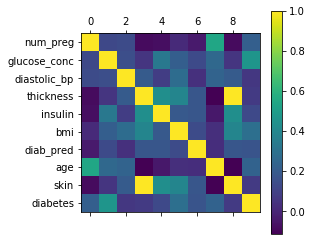

In [208]:
# Check for correlated values
import matplotlib.pyplot as plt
#%matplotlib inline  
corr = df.corr()
# fig, ax = plt.subplots()
plt.matshow(corr)
plt.yticks(range(len(corr.columns)), corr.columns);
plt.colorbar()
plt.show()

In [209]:
# Delete redundant column
del df['skin']
col_names = df.columns.values

In [210]:
# Check for missing data in the form of zero values
(df == 0).astype(int).sum(axis=0) # sum across columns

num_preg        111
glucose_conc      5
diastolic_bp     35
thickness       227
insulin         374
bmi              11
diab_pred         0
age               0
diabetes        500
dtype: int64

In [211]:
# Convert boolean column to int
df['diabetes'] = df['diabetes'].astype('int')
print(df.head())

   num_preg  glucose_conc  diastolic_bp  thickness  insulin   bmi  diab_pred  \
0         6           148            72         35        0  33.6      0.627   
1         1            85            66         29        0  26.6      0.351   
2         8           183            64          0        0  23.3      0.672   
3         1            89            66         23       94  28.1      0.167   
4         0           137            40         35      168  43.1      2.288   

   age  diabetes  
0   50         1  
1   31         0  
2   32         1  
3   21         0  
4   33         1  


In [212]:
# Check proportion of True rows
import numpy as np

def print_true_false_ratio(data):
    if type(data) == pd.DataFrame:
        count_true = len(data.loc[data['diabetes'] == 1])
        count_false = len(data.loc[data['diabetes'] == 0])
    elif type(data) == np.ndarray: # one-column numpy array
        count_true = data.sum()
        count_false = len(data[data == 0])
    total = count_true + count_false
    print(f"Number of positives: {count_true} out of {total} ({count_true*100.0/total:.2f}%).")
    print(f"Number of negatives: {count_false} out of {total} ({count_false*100.0/total:.2f}%).")
    
print_true_false_ratio(df)

Number of positives: 268 out of 768 (34.90%).
Number of negatives: 500 out of 768 (65.10%).


## Visualize distribution of the features

In [200]:
# Distribution of the bmi column
bmi_mean = { i:np.mean(X_train[(y_train==i).squeeze(),5]) for i in range(2) }
bmi_std = { i:np.std(X_train[(y_train==i).squeeze(),5]) for i in range(2) }

print("Healthy bmi distribution parameters:", bmi_mean[0], bmi_std[0])
print("Diabetes bmi distribution parameters:", bmi_mean[1], bmi_std[1])

Healthy bmi distribution parameters: 30.53582954520973 6.4756963513937
Diabetes bmi distribution parameters: 35.50678791393377 6.662308513710704


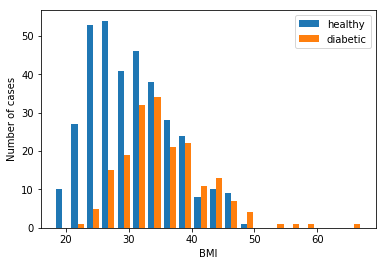

In [201]:
plt.hist((X_train[(y_train==0).squeeze(),5],X_train[(y_train==1).squeeze(),5]), bins=20, label=('healthy','diabetic'));
plt.xlabel("BMI");
plt.ylabel("Number of cases")
plt.legend();

In [215]:
features_means = { i: df[df['diabetes'] == i].iloc[:,:-1].mean(axis = 0) for i in range(2)}
features_stdevs = { i: df[df['diabetes'] == i].iloc[:,:-1].std(axis = 0) for i in range(2)}
print(features_means)
print(features_stdevs)

{0: num_preg          3.298000
glucose_conc    109.980000
diastolic_bp     68.184000
thickness        19.664000
insulin          68.792000
bmi              30.304200
diab_pred         0.429734
age              31.190000
dtype: float64, 1: num_preg          4.865672
glucose_conc    141.257463
diastolic_bp     70.824627
thickness        22.164179
insulin         100.335821
bmi              35.142537
diab_pred         0.550500
age              37.067164
dtype: float64}
{0: num_preg         3.017185
glucose_conc    26.141200
diastolic_bp    18.063075
thickness       14.889947
insulin         98.865289
bmi              7.689855
diab_pred        0.299085
age             11.667655
dtype: float64, 1: num_preg          3.741239
glucose_conc     31.939622
diastolic_bp     21.491812
thickness        17.679711
insulin         138.689125
bmi               7.262967
diab_pred         0.372354
age              10.968254
dtype: float64}


## Split the data into training and test sets

In [98]:
import sklearn

input_col_names = list(df.columns.values) # predictor columns
del input_col_names[input_col_names.index('diabetes')]
output_col_names = ['diabetes'] # output column
X = df[input_col_names].values # input data as ndarray
y = df[output_col_names].values # output data as ndarray
split_test_size = 0.3

X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(X, y, test_size=split_test_size, random_state=42)
print("Size and type of post-split data:\n",
      X_train.shape, type(X_train), "\n",
      X_test.shape, type(X_train), "\n",
      y_train.shape, type(y_train), "\n", 
      y_test.shape, type(y_test))


Size and type of post-split data:
 (537, 8) <class 'numpy.ndarray'> 
 (231, 8) <class 'numpy.ndarray'> 
 (537, 1) <class 'numpy.ndarray'> 
 (231, 1) <class 'numpy.ndarray'>


In [114]:
# Check that the proportion of True rows remains unchanged
print("In training data:")
print_true_false_ratio(y_train)
print("In test data:")
print_true_false_ratio(y_test)

In training data:
Number of positives: 188 out of 537 (35.01%).
Number of negatives: 349 out of 537 (64.99%).
In test data:
Number of positives: 80 out of 231 (34.63%).
Number of negatives: 151 out of 231 (65.37%).


In [102]:
# Fix null values by replacing them with the mean
imputer = sklearn.preprocessing.Imputer(missing_values=0, strategy='mean', axis=0, verbose=1)
print("Number of zero values:", (X_train == 0).sum(axis=0), "and", (X_test == 0).sum(axis=0))
X_train = imputer.fit_transform(X_train)
X_test = imputer.fit_transform(X_test)
print("type(X_train) =", type(X_train))
print("type(X_test) =", type(X_test))

Number of zero values: [0 0 0 0 0 0 0 0] and [0 0 0 0 0 0 0 0]
type(X_train) = <class 'numpy.ndarray'>
type(X_test) = <class 'numpy.ndarray'>


In [103]:
print("Number of zero values:", (X_train == 0).sum(axis=0), "and", (X_test == 0).sum(axis=0))

Number of zero values: [0 0 0 0 0 0 0 0] and [0 0 0 0 0 0 0 0]


## Select and train the model

In [104]:
import sklearn.naive_bayes

nb_model = sklearn.naive_bayes.GaussianNB()
nb_model.fit(X_train, y_train.ravel())

GaussianNB(priors=None)

## Display model parameters

In [151]:
print(nb_model.class_prior_)

[0.64990689 0.35009311]


## Evaluate performance of the model

In [118]:
import sklearn.metrics

y_train_predicted = nb_model.predict(X_train)
y_test_predicted = nb_model.predict(X_test)
print(f"Prediction accuracy on training data = {sklearn.metrics.accuracy_score(y_train, y_train_predicted):.4f}")
print(f"Prediction accuracy on test data = {sklearn.metrics.accuracy_score(y_test, y_test_predicted):.4f}")

Prediction accuracy on training data = 0.7542
Prediction accuracy on test data = 0.7359


In [125]:
print("Confusion matrix of training data (columns: predicted values, rows: actual values):")
confusion_train = sklearn.metrics.confusion_matrix(y_train, y_train_predicted)
print(confusion_train)
print("Number of predicted vs actual positives:", confusion_train[:, 1].sum(), "vs", confusion_train[1,:].sum(), "out of", confusion_train.sum())

print("Confusion matrix of test data:")
confusion_test = sklearn.metrics.confusion_matrix(y_test, y_test_predicted)
TN = confusion_test[0, 0]
FP = confusion_test[0, 1]
FN = confusion_test[1, 0]
TP = confusion_test[1, 1]

print(confusion_test)
print("Number of predicted vs actual positives:", confusion_test[:, 1].sum(), "vs", confusion_test[1,:].sum(), "out of", confusion_test.sum())

Confusion matrix of training data (columns: predicted values, rows: actual values):
[[293  56]
 [ 76 112]]
Number of predicted vs actual positives: 168 vs 188 out of 537
Confusion matrix of test data:
[[118  33]
 [ 28  52]]
Number of predicted vs actual positives: 85 vs 80 out of 231


In [133]:
print("Classification report:")
print(sklearn.metrics.classification_report(y_test, y_test_predicted))
precision = TP/(TP+FP) # true positives / predicted positives
print("Precision =", precision)
recall = TP/(FN+TP) # true positives / actual positives
print("Recall =", recall)
print("F1-score =", 1.0/((1.0/recall + 1.0/precision)/2))

Classification report:
             precision    recall  f1-score   support

          0       0.81      0.78      0.79       151
          1       0.61      0.65      0.63        80

avg / total       0.74      0.74      0.74       231

Precision = 0.611764705882353
Recall = 0.65
F1-score = 0.6303030303030304


## Perform explicit calculation

In [174]:
y_train = y_train.squeeze() # remove unused 2nd dimension so that we can use y_train as a boolean mask
means = { i: X_train[y_train == i].mean(axis = 0) for i in range(2)}
print("Features:", col_names[:-1])
print("Means by outcome and by column:\n", means)
stdev = { i: X_train[y_train == i].std(axis = 0) for i in range(2)}
print("Standard deviations by outcome and by column:\n", stdev)

Features: ['num_preg' 'glucose_conc' 'diastolic_bp' 'thickness' 'insulin' 'bmi'
 'diab_pred' 'age']
Means by outcome and by column:
 {0: array([  3.86443449, 110.550014  ,  70.67878439,  27.33401662,
       140.95224451,  30.53582955,   0.43257307,  30.67621777]), 1: array([  5.2244427 , 143.21260598,  75.14196377,  31.08588412,
       182.03014184,  35.50678791,   0.53925   ,  37.52659574])}
Standard deviations by outcome and by column:
 {0: array([ 2.67068844, 23.48536947, 11.98608083,  8.52365335, 71.69218763,
        6.47569635,  0.31288826, 11.30844103]), 1: array([ 3.061663  , 29.53709944, 12.04324733,  7.78833398, 99.89909052,
        6.66230851,  0.38014227, 11.0185692 ])}


In [205]:
import math

def calc_gaussian_density(x, mean, stdev):
    exponent = math.exp(-(x-mean)**2/(2*stdev**2))
    return (1 / (math.sqrt(2*math.pi) * stdev)) * exponent

vect_density = np.vectorize(calc_gaussian_density)
prob_healthy = vect_density(X_train, means[0], stdev[0])
prob_diabetes = vect_density(X_train, means[1], stdev[1])
prob_healthy = prob_healthy.prod(axis=1) * len(y_train[y_train == 0]) / len(y_train)
prob_diabetes = prob_diabetes.prod(axis=1)* len(y_train[y_train == 1]) / len(y_train)
print("Same results as Scikit-Learn:", np.array_equal((prob_healthy < prob_diabetes).astype(int), y_train_predicted))


Same results as Scikit-Learn: True
